# **Imports:**

In [1]:
import os
import zipfile
import shutil
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
zip_path = "/content/drive/MyDrive/Datasets2/new_data.zip"
extract_path = "/content/realwaste"

In [4]:
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

data_dir = extract_path
print(f"Dataset: {data_dir}")

Dataset: /content/realwaste


In [33]:
inner_folder = os.path.join(extract_path, "new_data")
if os.path.exists(inner_folder):
    for folder_name in os.listdir(inner_folder):
        src = os.path.join(inner_folder, folder_name)
        dst = os.path.join(extract_path, folder_name)
        shutil.move(src, dst)
    os.rmdir(inner_folder)
data_dir = extract_path

In [52]:
import os, random
from PIL import Image
import matplotlib.pyplot as plt

cats = [d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))
        and any(f.lower().endswith(('.png','.jpg','.jpeg')) for f in os.listdir(os.path.join(data_dir, d)))]




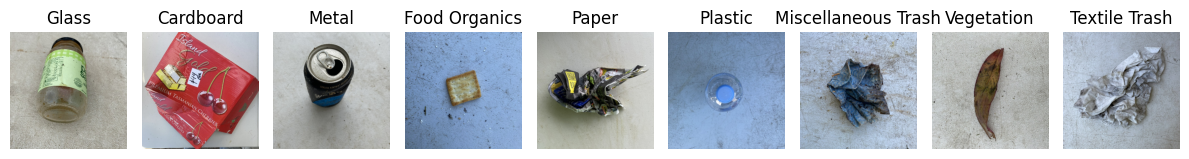

In [53]:
plt.figure(figsize=(12,6))
for i, cat in enumerate(cats, 1):
    cat_path = os.path.join(data_dir, cat)
    imgs = [f for f in os.listdir(cat_path) if f.lower().endswith(('.png','.jpg','.jpeg'))]
    if imgs:
        img_path = os.path.join(cat_path, random.choice(imgs))
        img = Image.open(img_path).convert("RGB")
        plt.subplot(2, len(cats), i)
        plt.imshow(img)
        plt.title(cat)
        plt.axis('off')

plt.tight_layout()
plt.show()

In [35]:
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])

full_dataset = datasets.ImageFolder(root=data_dir, transform=transform)
dataset_size = len(full_dataset)

train_ratio = 0.7
val_ratio = 0.1
test_ratio = 0.2

train_size = int(train_ratio * dataset_size)
val_size = int(val_ratio * dataset_size)
test_size = dataset_size - train_size - val_size

train_data, val_data, test_data = random_split(full_dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

class_names = full_dataset.classes
num_classes = len(class_names)
print(f"Detected Classes: {class_names}")
print(f"Train: {len(train_data)}, Validation: {len(val_data)}, Test: {len(test_data)}")


Classes: ['Cardboard', 'Food Organics', 'Glass', 'Metal', 'Miscellaneous Trash', 'Paper', 'Plastic', 'Textile Trash', 'Vegetation', 'realwaste-main']
Train: 4671, Validation: 667, Test: 1335


# **CNN implementation:**

In [9]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3,64,3,padding=1), nn.ReLU(inplace=True), nn.MaxPool2d(2,2),
            nn.Conv2d(64,128,3,padding=1), nn.ReLU(inplace=True), nn.MaxPool2d(2,2),
            nn.Conv2d(128,256,3,padding=1), nn.ReLU(inplace=True), nn.MaxPool2d(2,2),
            nn.Conv2d(256,512,3,padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(512,512,3,padding=1), nn.ReLU(inplace=True), nn.MaxPool2d(2,2)
        )
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((1,1)),
            nn.Flatten(),
            nn.Linear(512, num_classes)
        )

    def forward(self,x):
        x = self.features(x)
        x = self.classifier(x)
        return x

In [56]:
print(model)

SimpleCNN(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU(inplace=True)
    (11): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): AdaptiveAvgPool2d(output_size=(1, 1))
    (1): Flatten(start_

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleCNN(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [12]:
import matplotlib.pyplot as plt

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=5):

    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += (outputs.argmax(dim=1) == labels).sum().item()

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects / len(train_loader.dataset)
        train_losses.append(epoch_loss)
        train_accs.append(epoch_acc)

        model.eval()
        val_loss = 0.0
        val_corrects = 0
        with torch.no_grad():
            for val_inputs, val_labels in val_loader:
                val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
                val_outputs = model(val_inputs)
                loss = criterion(val_outputs, val_labels)
                val_loss += loss.item() * val_inputs.size(0)
                val_corrects += (val_outputs.argmax(dim=1) == val_labels).sum().item()
        val_loss /= len(val_loader.dataset)
        val_acc = val_corrects / len(val_loader.dataset)
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        print(f"Epoch {epoch+1}/{num_epochs} | "
              f"Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f} | "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    plt.figure(figsize=(10, 4))

    plt.subplot(1, 2, 1)
    plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
    plt.plot(range(1, num_epochs+1), val_losses, label='Val Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training vs Validation Loss')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(range(1, num_epochs+1), train_accs, label='Train Acc')
    plt.plot(range(1, num_epochs+1), val_accs, label='Val Acc')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training vs Validation Accuracy')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()


# **Training:**

Epoch 1/10 | Train Loss: 2.0744, Train Acc: 0.2822 | Val Loss: 1.9116, Val Acc: 0.3193
Epoch 2/10 | Train Loss: 1.8437, Train Acc: 0.3158 | Val Loss: 1.6884, Val Acc: 0.3538
Epoch 3/10 | Train Loss: 1.6571, Train Acc: 0.3603 | Val Loss: 1.6326, Val Acc: 0.3688
Epoch 4/10 | Train Loss: 1.5800, Train Acc: 0.3689 | Val Loss: 1.5853, Val Acc: 0.3493
Epoch 5/10 | Train Loss: 1.5197, Train Acc: 0.3899 | Val Loss: 1.4950, Val Acc: 0.4303
Epoch 6/10 | Train Loss: 1.5143, Train Acc: 0.3922 | Val Loss: 1.4954, Val Acc: 0.4153
Epoch 7/10 | Train Loss: 1.4644, Train Acc: 0.4190 | Val Loss: 1.4456, Val Acc: 0.4288
Epoch 8/10 | Train Loss: 1.4145, Train Acc: 0.4350 | Val Loss: 1.4134, Val Acc: 0.4273
Epoch 9/10 | Train Loss: 1.3730, Train Acc: 0.4547 | Val Loss: 1.4424, Val Acc: 0.4273
Epoch 10/10 | Train Loss: 1.3456, Train Acc: 0.4579 | Val Loss: 1.3830, Val Acc: 0.4438


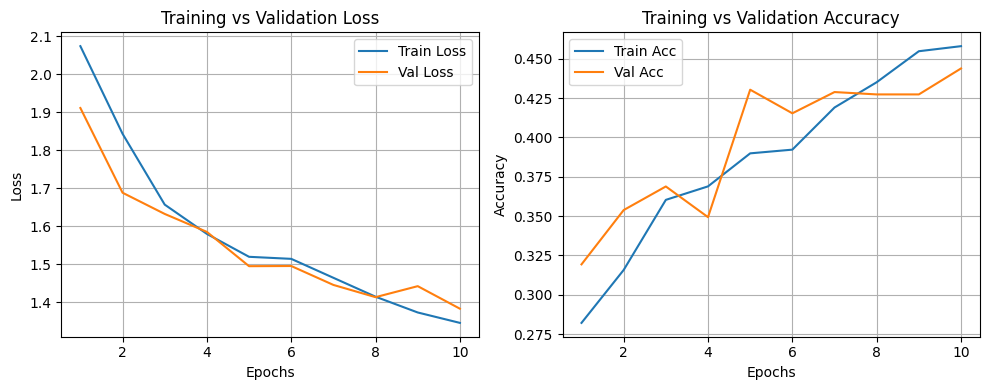

In [13]:
train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10)

# **GradCAM:**

In [41]:
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        target_layer.register_forward_hook(self._save_acts)
        target_layer.register_full_backward_hook(self._save_grads)

    def _save_acts(self, m, i, o): self.activations = o.detach()
    def _save_grads(self, m, gi, go): self.gradients = go[0].detach()

    def __call__(self, x, target_class=None):
        self.model.zero_grad()
        out = self.model(x)
        if target_class is None: target_class = out.argmax(dim=1).item()
        one_hot = torch.zeros_like(out).to(x.device)
        one_hot[0, target_class] = 1
        out.backward(gradient=one_hot, retain_graph=True)
        w = self.gradients.mean(dim=(2,3), keepdim=True)
        cam = F.relu((w * self.activations).sum(1, keepdim=True))
        if cam.max() > 0: cam = (cam - cam.min()) / cam.max()
        return F.interpolate(cam, size=x.shape[2:], mode='bilinear', align_corners=False).squeeze().cpu().numpy()

grad_cam = GradCAM(model, model.features[8])


In [42]:
def plot_grad_cam(img_tensor, cam, predicted_class, true_class, class_names):
    fig, axs = plt.subplots(1,2,figsize=(10,5))
    img = denormalize_image(img_tensor.squeeze(0)).permute(1,2,0).cpu().numpy()
    axs[0].imshow(img)
    axs[0].set_title(f"True: {class_names[true_class]}\nPred: {class_names[predicted_class]}")
    axs[0].axis('off')
    axs[1].imshow(img)
    axs[1].imshow(cam, cmap='jet', alpha=0.5)
    axs[1].set_title("Grad-CAM Heatmap")
    axs[1].axis('off')
    plt.show()


In [43]:
def denormalize_image(tensor):
    device = tensor.device
    mean = torch.tensor([0.485, 0.456, 0.406], device=device).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225], device=device).view(3, 1, 1)
    tensor = tensor * std + mean
    return torch.clamp(tensor, 0, 1)

# **Results:**

Sample 1: True = Pred = Glass


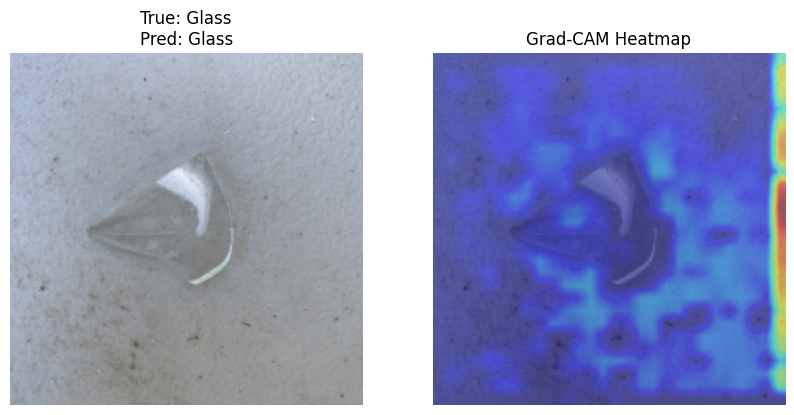

Sample 2: True = Pred = Cardboard


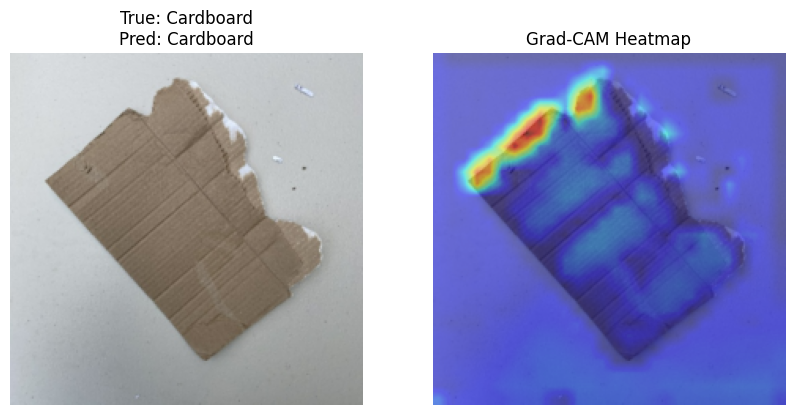

Sample 3: True = Pred = Cardboard


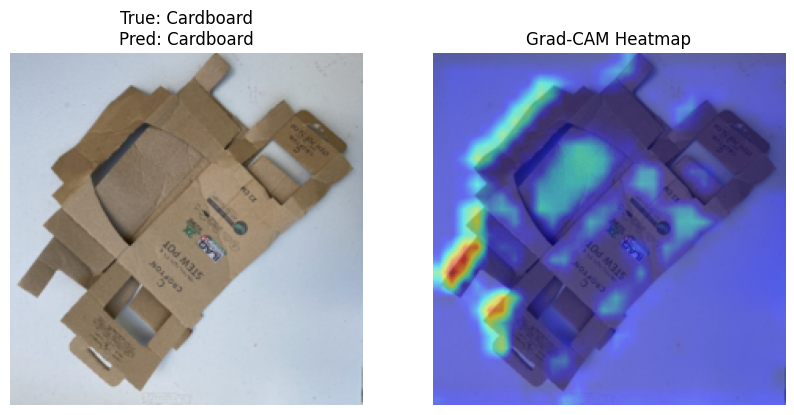

Sample 4: True = Pred = Glass


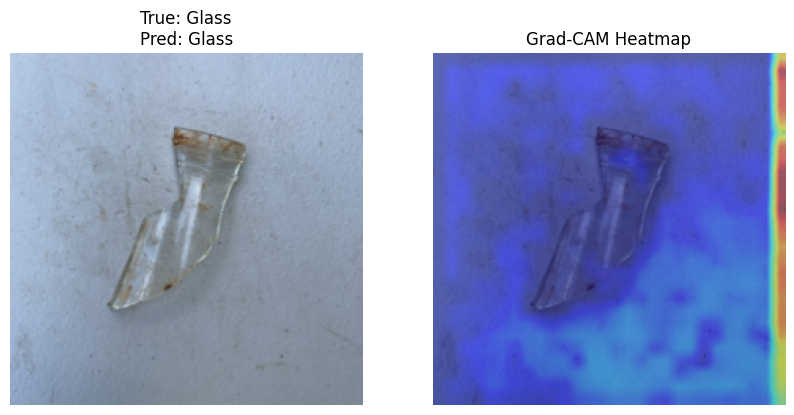

Sample 5: True = Pred = Glass


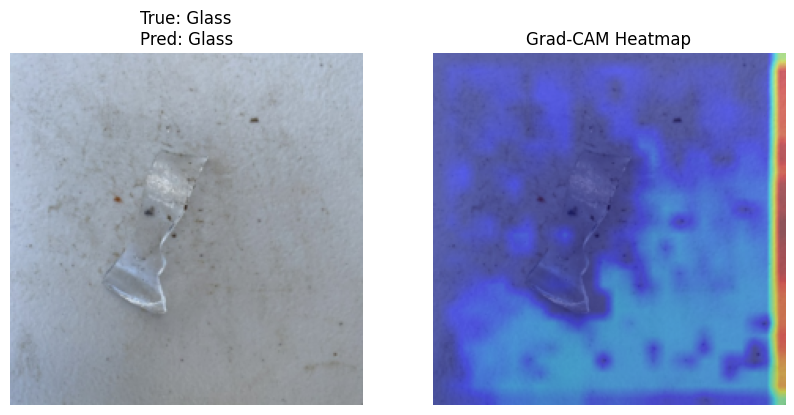

Sample 6: True = Pred = Paper


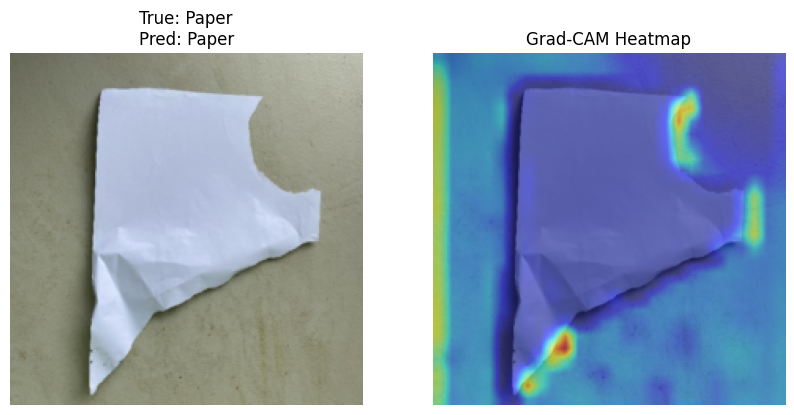

Sample 7: True = Pred = Metal


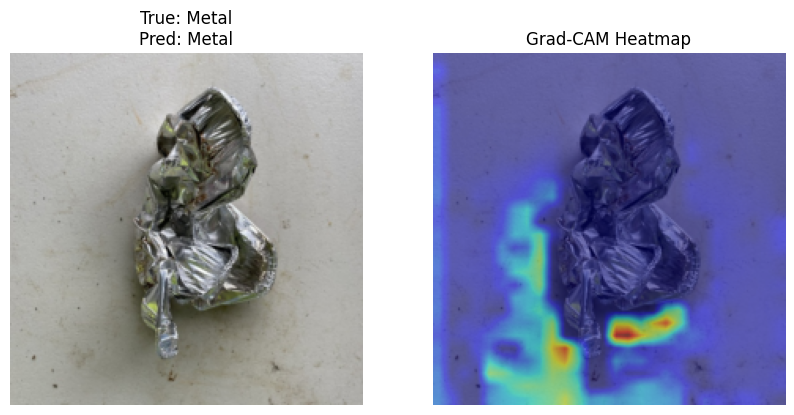

Sample 8: True = Pred = Metal


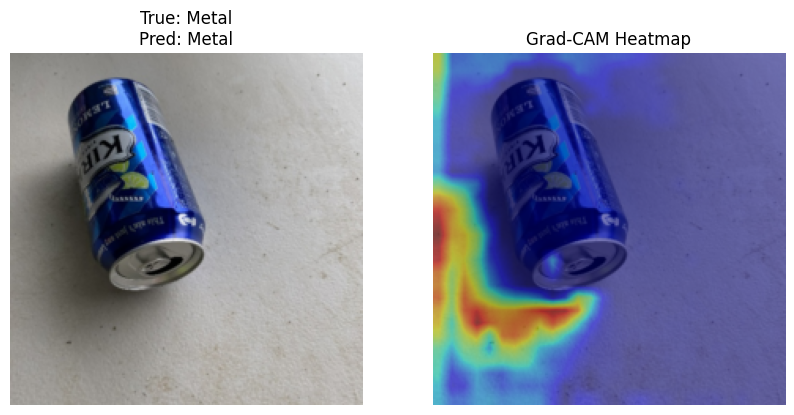

Sample 9: True = Pred = Vegetation


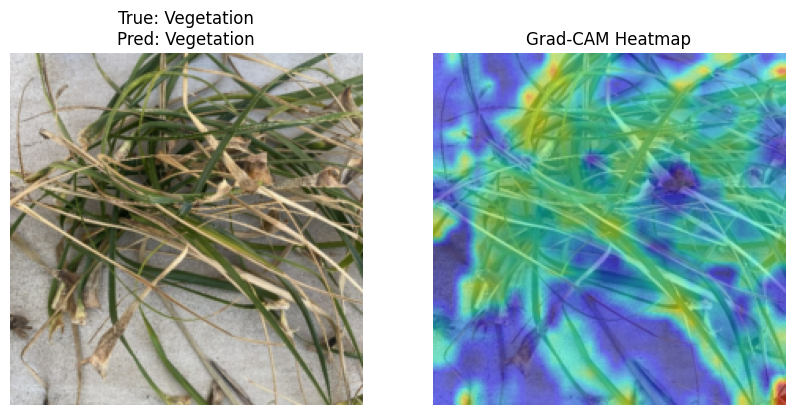

Sample 10: True = Pred = Cardboard


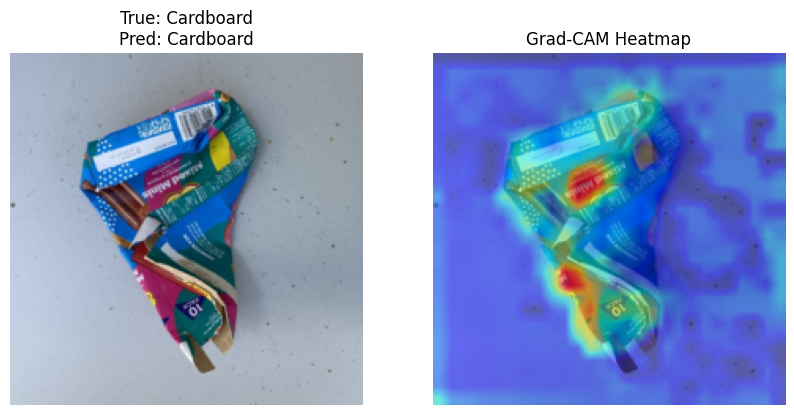

Sample 11: True = Pred = Food Organics


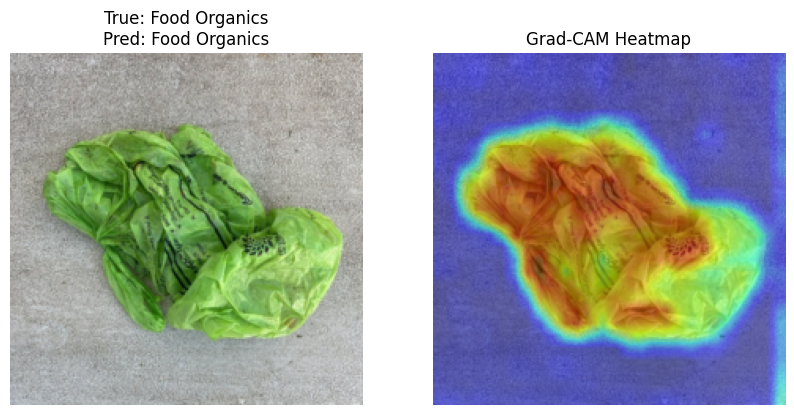

Sample 12: True = Pred = Food Organics


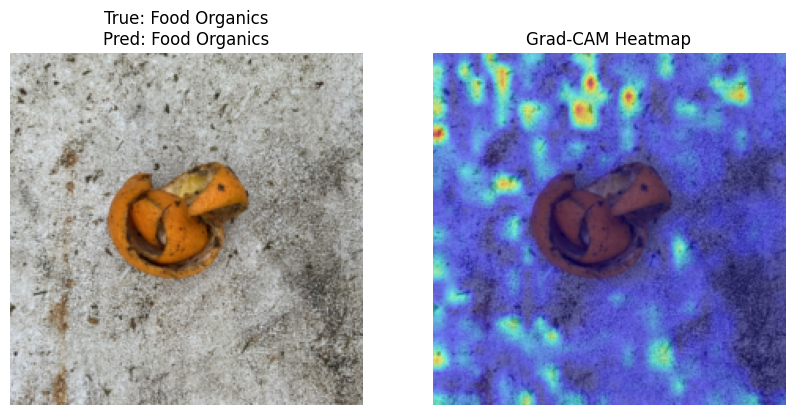

Sample 13: True = Pred = Plastic


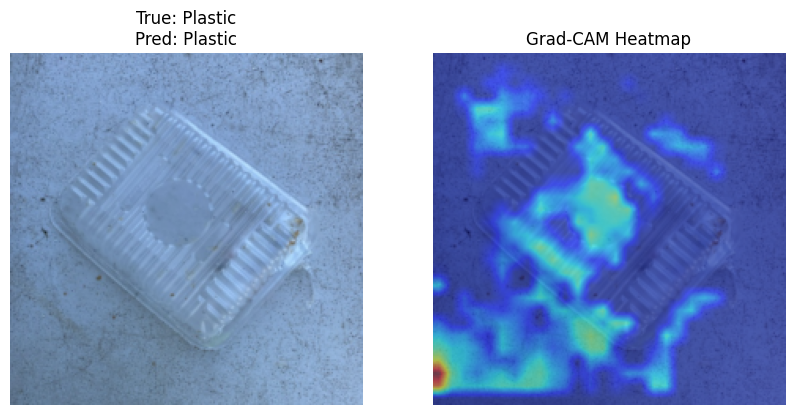

Sample 14: True = Pred = Vegetation


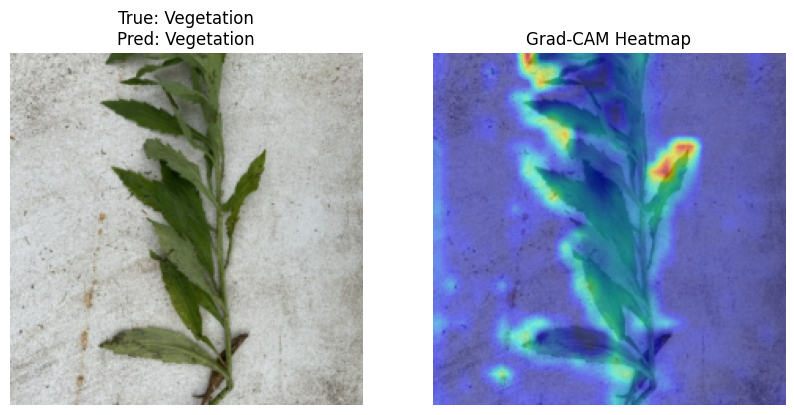

Sample 15: True = Pred = Glass


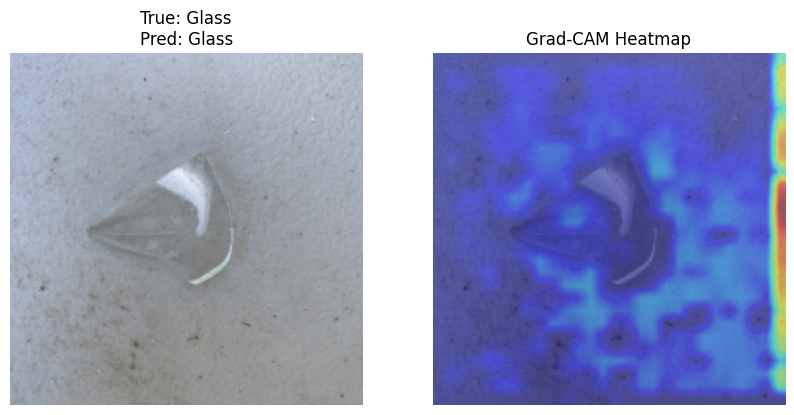

Sample 16: True = Pred = Cardboard


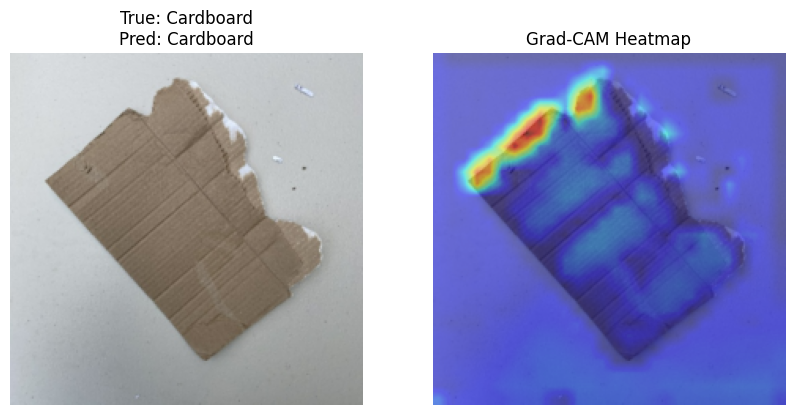

Sample 17: True = Pred = Cardboard


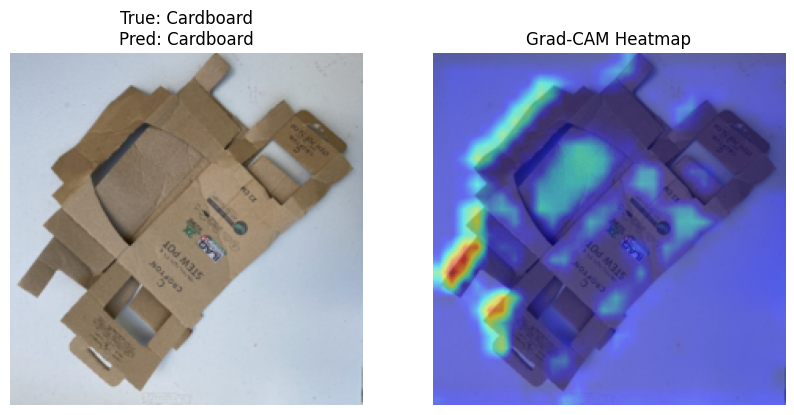

Sample 18: True = Pred = Glass


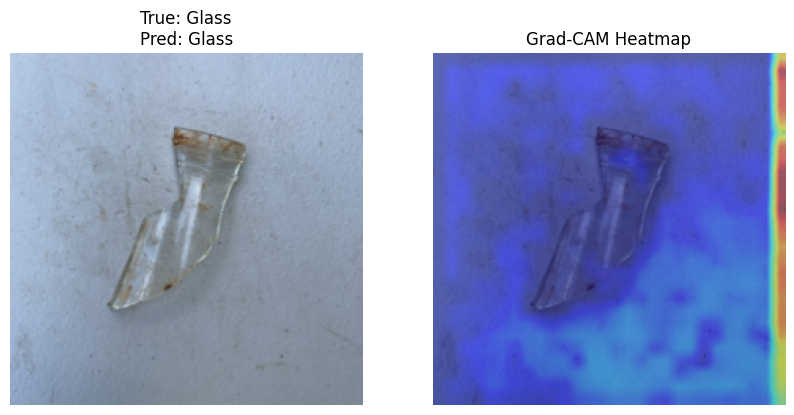

Sample 19: True = Pred = Glass


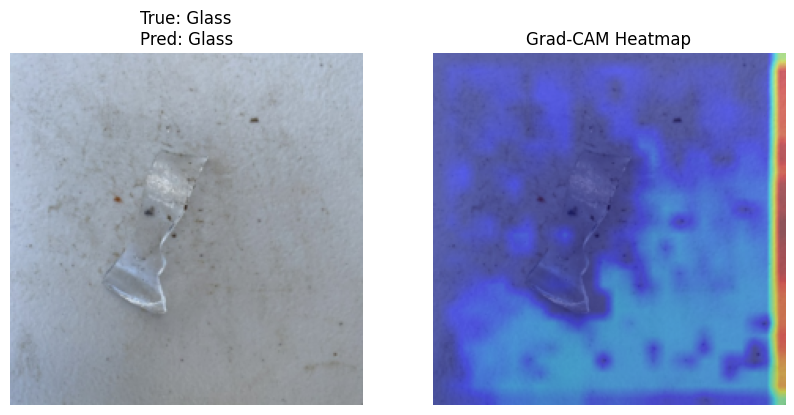

Sample 20: True = Pred = Paper


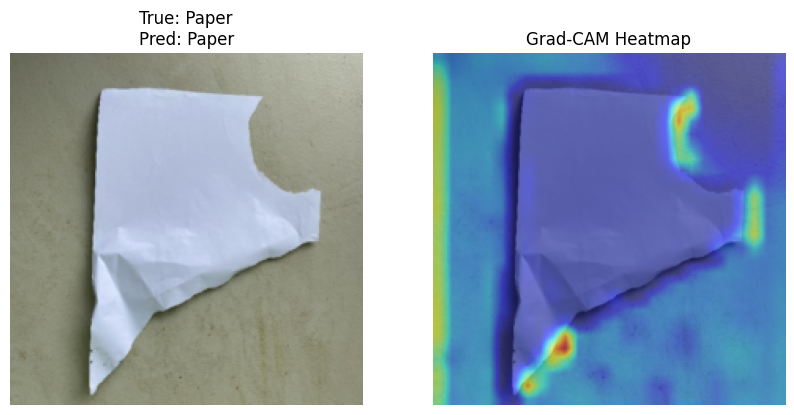

In [47]:
model.eval()



test_iterator = iter(test_loader)
shown = 0
max_samples = 20
ignore_class = "realwaste-main"

while shown < max_samples:
    try:
        inputs, labels = next(test_iterator)
    except StopIteration:
        test_iterator = iter(test_loader)
        inputs, labels = next(test_iterator)

    input_tensor = inputs[0:1].to(device)
    true_label = labels[0].item()

    with torch.no_grad():
        output = model(input_tensor)
        predicted_label = output.argmax(dim=1).item()

    true_name = class_names[true_label]
    pred_name = class_names[predicted_label]

    if predicted_label == true_label and true_name != ignore_class and pred_name != ignore_class:
        with torch.enable_grad():
            cam = grad_cam(input_tensor, predicted_label)

        print(f"Sample {shown+1}: True = Pred = {true_name}")
        plot_grad_cam(input_tensor, cam, predicted_label, true_label, class_names)
        shown += 1
